In [ ]:
import torch
import torch.nn as nn
import numpy as np
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)

        )
    def forward(self, x, t):
        inputs = torch.cat([x, t], dim = 1)
        u = self.hidden(inputs)
        return u
    print("Hiefere")

Hiefere


In [ ]:
# define the pde residual function
def pde_residual(x, t, model, nu = 0.01):

    x.requires_grad = True
    t.requires_grad = True

    u = model(x, t) #predict u from the model
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]


    residual = u_t + u * u_x - nu * u_xx
    return residual

#initial and boundary condiitons
def initial_condition(x):
    return -torch.sin(np.pi * x)

def boundary_condition(x, t):
    return torch.zeros_like(t)
print("2")



2


In [ ]:
#train the model
x = torch.linspace(-1, 1, 200).view(-1, 1)
t = torch.linspace(0, 1, 100).view(-1, 1)
x_train, t_train = torch.meshgrid(x.squeeze(), t.squeeze(), indexing = 'xy')
x_train = x_train.reshape(-1, 1)
t_train = t_train.reshape(-1, 1)
print("hi")

hi


In [ ]:
#define the model, optimizer, and loss function
import torch.optim as optim
import torch.nn as nn
loss_fn = nn.MSELoss()


model = PINN()
optimizer = optim.Adam(model.parameters(), lr = 0.01)


In [ ]:
num_epochs = 12000
print("Hi")
for each in range(num_epochs):
    model.train()

    # Compute initial condition loss
    u_pred = model(x, torch.zeros_like(x))
    u_true = initial_condition(x)
    loss_ic = torch.mean((u_pred - u_true)**2)

    # Compute boundary condition loss
    u_pred_left = model(torch.full_like(t, -1), t) # u(-1, t)
    u_pred_right = model(torch.full_like(t, 1), t) # u(1, t)
    loss_bc = torch.mean((u_pred_left - boundary_condition(torch.full_like(t, -1), t))**2) + \
              torch.mean((u_pred_right - boundary_condition(torch.full_like(t, 1), t))**2)

    # Compute PDE residual loss
    residual = pde_residual(x_train, t_train, model)
    loss_pde = torch.mean(residual**2)

    loss = loss_ic + loss_bc + loss_pde

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
#     print("Hi")

    if each % 500 == 0:
        print(f'Epoch [{each + 1}/{num_epochs}], Loss: {loss.item():.4f}')




Hi
Epoch [1/12000], Loss: 0.5149
Epoch [501/12000], Loss: 0.0207
Epoch [1001/12000], Loss: 0.0079
Epoch [1501/12000], Loss: 0.0043
Epoch [2001/12000], Loss: 0.0090
Epoch [2501/12000], Loss: 0.0015
Epoch [3001/12000], Loss: 0.0010
Epoch [3501/12000], Loss: 0.0045
Epoch [4001/12000], Loss: 0.0078
Epoch [4501/12000], Loss: 0.0010
Epoch [5001/12000], Loss: 0.0004
Epoch [5501/12000], Loss: 0.0004
Epoch [6001/12000], Loss: 0.0018
Epoch [6501/12000], Loss: 0.0003
Epoch [7001/12000], Loss: 0.0002
Epoch [7501/12000], Loss: 0.0006
Epoch [8001/12000], Loss: 0.0002
Epoch [8501/12000], Loss: 0.0002
Epoch [9001/12000], Loss: 0.0004
Epoch [9501/12000], Loss: 0.0002
Epoch [10001/12000], Loss: 0.0014
Epoch [10501/12000], Loss: 0.0003
Epoch [11001/12000], Loss: 0.0002
Epoch [11501/12000], Loss: 0.0001


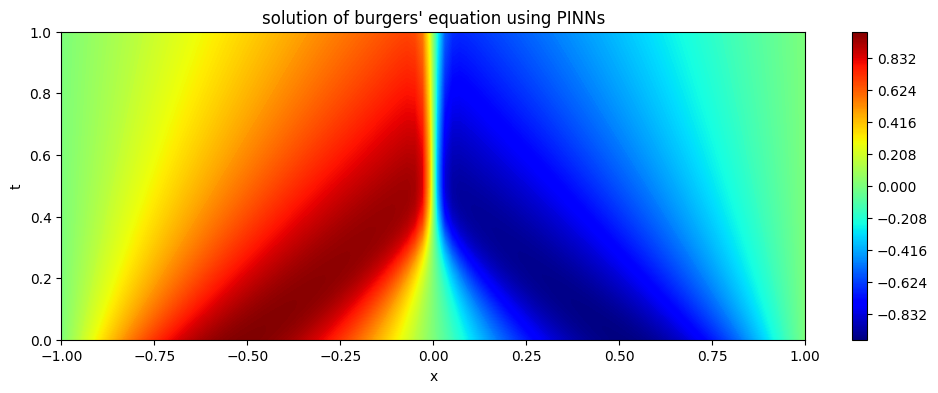

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

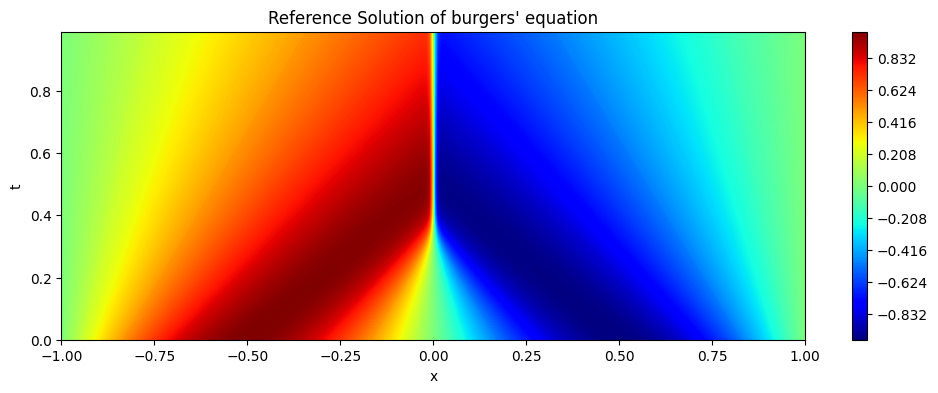

In [ ]:
# evaluate the model on a grid of (x, t) values
import matplotlib.pyplot as plt
x_test = torch.linspace(-1, 1, 100).view(-1, 1)
t_test = torch.linspace(0, 1, 100).view(-1, 1)
x_test, t_test  = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing = 'xy')
x_test = x_test.reshape(-1, 1)
t_test = t_test.reshape(-1, 1)

model.eval()
with torch.no_grad():
    u_pred = model(x_test, t_test).numpy()

# reshape the predicted u values for contour plotting
x_test = x_test.numpy().reshape(100, 100)
t_test = t_test.numpy().reshape(100, 100)
u_pred = u_pred.reshape(100, 100)

#plot the PINN solution as a contour plot
plt.figure(figsize = (12, 4))
plt.contourf(x_test, t_test, u_pred, levels = 250, cmap = 'jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('solution of burgers\' equation using PINNs')
plt.show()

#load the reference solution data
data= np.load("Burgers.npz")
t_ref, x_ref, exact = data["t"], data["x"], data["usol"].T
#Reshape
x_ref, t_ref = np.meshgrid(x_ref, t_ref)

# Define spatial and temporal grids
##x_ref = np.linspace(-1, 1, 100)  # 100 spatial points
#t_ref = np.linspace(0, 1, 100)  # 100 time points

# Example: Compute an analytical solution for visualization
#exact = np.sin(np.pi * x_ref[None, :]) * np.exp(-t_ref[:, None])

# Plot the reference solution as a contour plot
plt.figure(figsize=(12, 4))
plt.contourf(x_ref, t_ref, exact, levels=250, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Reference Solution of burgers\' equation')
from google.colab import files
# ✅ Save the figure before displaying
save_path = "burgers_contour_plot.png"

# ✅ Download the file in Colab
files.download(save_path)
plt.savefig("burgers_pinn_solution.png", dpi=300)
files.download("burgers_pinn_solution.png")

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from google.colab import files

# Create test grid
x_test = torch.linspace(-1, 1, 100).view(-1, 1)
t_test = torch.linspace(0, 1, 100).view(-1, 1)
x_test, t_test = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='xy')
x_test_flat = x_test.reshape(-1, 1)
t_test_flat = t_test.reshape(-1, 1)

# Predict using trained PINN model
model.eval()
with torch.no_grad():
    u_pred = model(x_test_flat, t_test_flat).numpy()

# Reshape predictions for contour plotting
x_test_np = x_test.numpy()
t_test_np = t_test.numpy()
u_pred = u_pred.reshape(100, 100)

# ✅ Plot PINN solution
plt.figure(figsize=(12, 4))
plt.contourf(x_test_np, t_test_np, u_pred, levels=250, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title("Solution of Burgers' Equation using PINNs")
plt.savefig("pinn_solution.png", dpi=300)  # Save plot
plt.close()  # Close plot to avoid double showing

# ✅ Download PINN solution
files.download("pinn_solution.png")

# Load reference solution
data = np.load("Burgers.npz")
t_ref, x_ref, exact = data["t"], data["x"], data["usol"].T
x_ref, t_ref = np.meshgrid(x_ref, t_ref)

# ✅ Plot reference solution
plt.figure(figsize=(12, 4))
plt.contourf(x_ref, t_ref, exact, levels=250, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title("Reference Solution of Burgers' Equation")
plt.savefig("reference_solution.png", dpi=300)  # Save plot
plt.close()  # Close plot

# ✅ Download reference solution
files.download("reference_solution.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

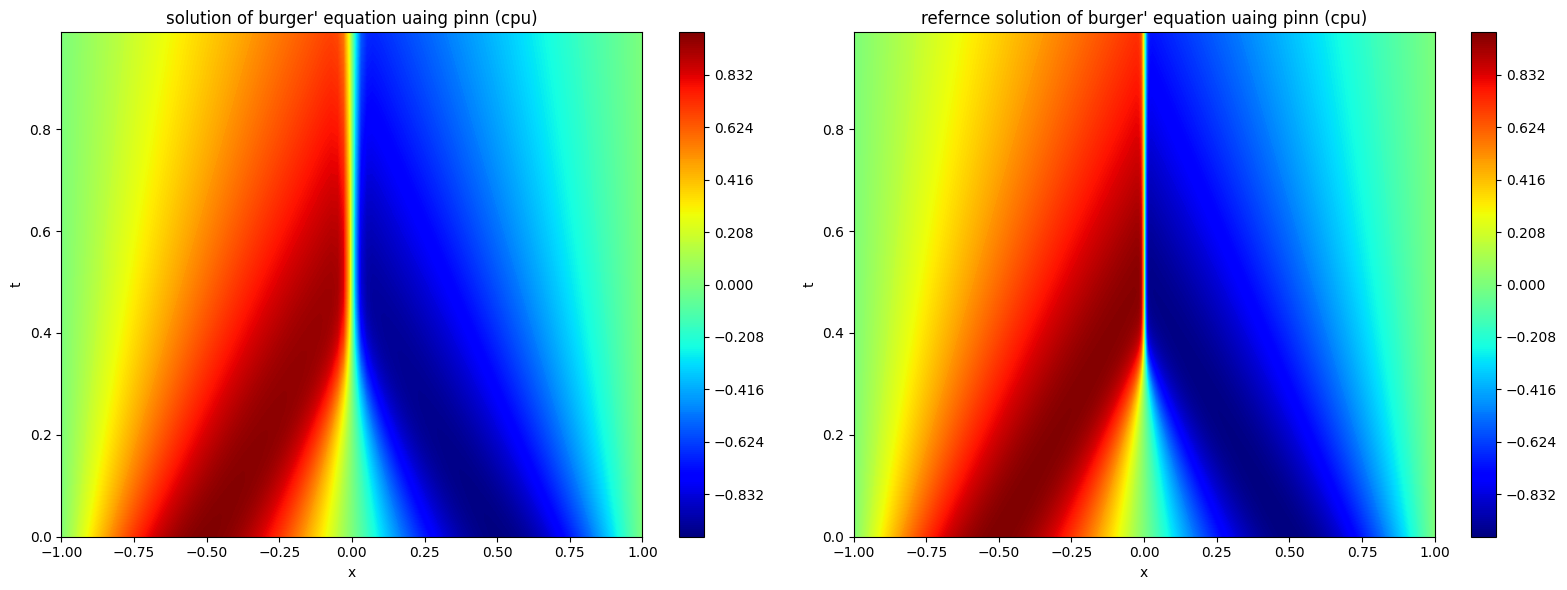

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [ ]:

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

contour1 = ax1.contourf(x_test, t_test, u_pred, levels = 250, cmap = 'jet')
fig.colorbar(contour1, ax = ax1)
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_title('solution of burger\' equation uaing pinn (cpu)')


#plot reference
contour2 = ax2.contourf(x_ref, t_ref, exact, levels = 250, cmap = 'jet')
fig.colorbar(contour2, ax = ax2)
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_title('refernce solution of burger\' equation uaing pinn (cpu)')
#set same limits for both plots
ax1.set_xlim([x_ref.min(), x_ref.max()])
ax1.set_ylim([t_ref.min(), t_ref.max()])
ax2.set_xlim([x_ref.min(), x_ref.max()])
ax2.set_ylim([t_ref.min(), t_ref.max()])

plt.tight_layout()

from google.colab import files
# ✅ Save the figure before displaying
save_path = "burgers_contour_plot.png"
fig.savefig(save_path, dpi=300)

# Display the plot
plt.show()

# ✅ Download the file in Colab
files.download(save_path)
plt.savefig("burgers_pinn_solution.png", dpi=300)
files.download("burgers_pinn_solution.png")

plt.show()






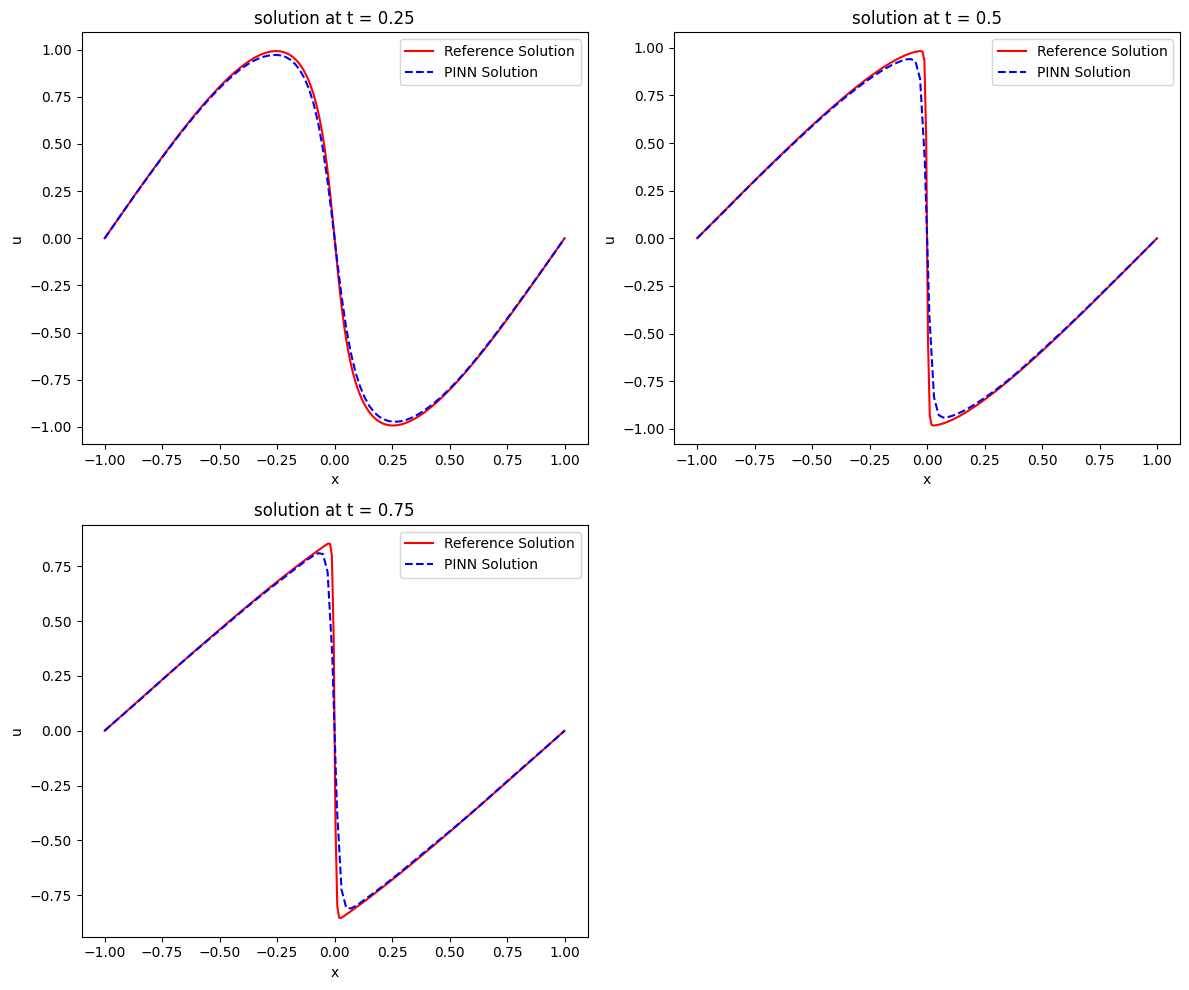

In [ ]:

import matplotlib.pyplot as plt

time_slices = [ 0.25, 0.5, 0.75]
num_plots= len(time_slices)
cols = 2
rows = (num_plots // cols) +(num_plots % cols)
fig, axs = plt.subplots(rows, cols, figsize = (12, 5*rows))
axs = axs.flatten()
for i, t_val in enumerate(time_slices):
    # Find closest time point in t_ref
    idx_ref = np.argmin(np.abs(t_ref[:,0] - t_val))
    u_ref_slice = exact[idx_ref,:]

    t_slice = t_val * np.ones((100, 1))
    x_slice = np.linspace(-1, 1, 100).reshape(-1, 1)

    model.eval()
    with torch.no_grad():
        u_pinn_slice = model(torch.tensor(x_slice, dtype=torch.float32),
                             torch.tensor(t_slice, dtype=torch.float32)).numpy()

    axs[i].plot(x_ref[0, :], u_ref_slice, 'r-', label='Reference Solution')
    axs[i].plot(x_slice, u_pinn_slice, 'b--', label='PINN Solution')

    axs[i].set_xlabel('x')
    axs[i].set_ylabel('u')
    axs[i].set_title(f'solution at t = {t_val}')
    axs[i].legend()

for j in range(num_plots, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from google.colab import files

time_slices = [0.25, 0.5, 0.75]

# Loop through each time slice
for i, t_val in enumerate(time_slices):
    # Find closest index in reference time
    idx_ref = np.argmin(np.abs(t_ref[:, 0] - t_val))
    u_ref_slice = exact[idx_ref, :]

    # Create slice arrays
    t_slice = t_val * np.ones((100, 1))
    x_slice = np.linspace(-1, 1, 100).reshape(-1, 1)

    # Evaluate model
    model.eval()
    with torch.no_grad():
        u_pinn_slice = model(torch.tensor(x_slice, dtype=torch.float32),
                             torch.tensor(t_slice, dtype=torch.float32)).numpy()

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(x_ref[0, :], u_ref_slice, 'r-', label='Reference Solution')
    plt.plot(x_slice, u_pinn_slice, 'b--', label='PINN Solution')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.title(f'Solution at t = {t_val}')
    plt.legend()
    plt.grid(True)

    # Save and download
    filename = f"solution_t_{t_val:.2f}.png"
    plt.savefig(filename, dpi=300)
    files.download(filename)
    plt.close()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np

# Initial condition: u(x, y, z, t=0) = v(x, y, z, t=0) = w(x, y, z, t=0) = 0
def initial_condition(x, y, z):
    return np.zeros((x.shape[0], 3))

# Boundary condition: u, v, w = 0 at the boundaries
def boundary_condition(x, y, z, t):
    return np.zeros((x.shape[0], 3))
